Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook e sua versão online pode ser encontrada aqui: https://colab.research.google.com/drive/1HQIBTnHCrcSrfAUOsx7836wZzDnQ9Fhd?usp=sharing. Nessa versão é possível executar novamente os algoritmos.

# Qual o problema ? 
Utilizar uma rede neural no modelo perceptron para identificar 3 classes de flores baseados em suas características de tamanho de pétalada e sépala.

## Importação das bibliotecas
Ferramentas usadas no processo de desenvolvimento

In [227]:
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

## Análise Exploratória dos Dados (AED)
Vamos entender um pouco mais do nosso *dataset*, e deixar os dados em um formato que seja favorável para o aprendizado da rede neural perceptron.

O primeiro passo foi ler o arquivo baixado aqui: http://archive.ics.uci.edu/ml/datasets/Iris.
O arquivo em questão não possuia colunas, portanto eu modifiquei o mesmo para adicionar o nome das colunas na primeira linha e deixá-lo no formato .CSV ao invés do .DATA. 

In [228]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/iris2.csv', header = 0)

dataframe.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Um passo inicial importante é verificar se o nosso *dataset* possui inconsistências quanto aos valores, podendo ser algum outlier, ruído, valor vazio, etc...

In [229]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Valores nulos:
sepal-length    0
sepal-width     0
petal-length    0
petal-width     0
class           0
dtype: int64


,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Mostrando a dispersão dos dados
Podemos plotar um gráfico para mostrar o comportamento da dispersão das classes do dataset, sendo possível inclusive ver se o problema é linearmente separável.

Antes disso, é necessário dividir o *dataframe* em uma variável chamada **previsores** e outra chamada **classe**, como o nome sugere, os previsores são as colunas com as características das flores que serão usadas para tentar ajustar os pesos da rede de maneira à generalizar uma solução que encontre as classes corretamente.

In [230]:
previsores = dataframe.iloc[:, 0:4] 
classe = dataframe['class']

<Figure size 432x288 with 0 Axes>

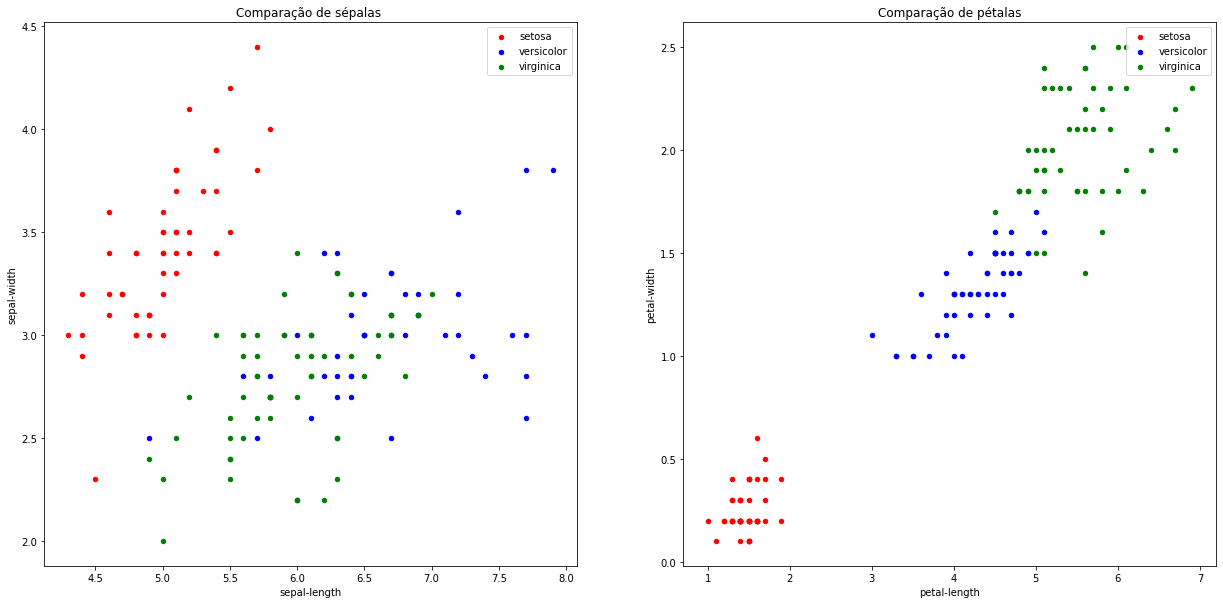

In [231]:
# iniciando a figura
plt.figure()
fig,ax=plt.subplots(1,2,figsize=(21, 10))

# separando o dataset por classe
setosa=dataframe[dataframe['class']=='Iris-setosa']
versicolor =dataframe[dataframe['class']=='Iris-versicolor']
virginica =dataframe[dataframe['class']=='Iris-virginica']
# plotando os conjuntos no gráfico de dispersão
setosa.plot(x="sepal-length", y="sepal-width", kind="scatter",ax=ax[0],label='setosa',color='r')
virginica.plot(x="sepal-length",y="sepal-width",kind="scatter",ax=ax[0],label='versicolor',color='b')
versicolor.plot(x="sepal-length", y="sepal-width", kind="scatter", ax=ax[0], label='virginica', color='g')

setosa.plot(x="petal-length", y="petal-width", kind="scatter",ax=ax[1],label='setosa',color='r')
versicolor.plot(x="petal-length",y="petal-width",kind="scatter",ax=ax[1],label='versicolor',color='b')
virginica.plot(x="petal-length", y="petal-width", kind="scatter", ax=ax[1], label='virginica', color='g')
# Adicionado legendas
ax[0].set(title='Comparação de sépalas ', ylabel='sepal-width')
ax[1].set(title='Comparação de pétalas',  ylabel='petal-width')
ax[0].legend()
ax[1].legend()
plt.show()

Podemos ver que as classes virgínica e versicolor são as mais complicadas de serem separadas, principalmente quando olhamos para o tamanho das pétalas

## Normalização dos atributos previsores
O método *isnul()* mostrou que não há nenhum registro vazio no nosso *dataset*, além disso, é possível observar que os valores também parecem estar todos coerentes, sem a presença de outliers, como podemos notar pelo desvio padrão, mínimo e máximo de cada coluna e o gráfico de dispersão.

Todavia, existe uma variação relativamente grande dentro do nosso domínio de atributos previsores. O atributo *petal-width* por exemplo, tem uma média de valor de 1.1, enquanto o *sepal-length* possui uma média de 5.8, portanto se faz necessário a padronização dos valores, para que nosso ajuste dos pesos não seja muito influenciado por essa diferença no tamanho da entrada. 

O tipo de normalização escolhido foi o **Z-score**, de forma arbitrária, por ser bastante comum em problemas como esse. Sua fórmula é bastante simples e foi representada no método *normalizacao_z_score*.
![](./images/zscore.png)

In [232]:
def normalizacao_z_score(valor):
    media = previsores[valor.name].mean()
    desvio_padrao = previsores[valor.name].std()

    return (valor - media) / desvio_padrao

O método *apply()* com a **lambda** aplicam o processo matemático do nosso método de normalização em cada um dos registros do *dataframe*. Os novos registros normalizados podem ser vistos abaixo.

In [233]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,sepal-length,sepal-width,petal-length,petal-width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593


## Tratando valores categóricos
O próximo passo será transformar o valor da nossa classe de categórico para discreto, para que seja possível aplicar os cálculos, como o erro da saída por exemplo.

Para isso foi criado o método *get_dicionario_classes* que gera uma estrutura de dicionário dinâmica, baseado na quantidade de classes do problema que está sendo tratado. O processo é muito simples, basta percorrer a classe existente e atribuir um valor inteiro para cada classe.

In [234]:
def get_dicionario_classes(classe):
    dict_classes = {}
    count = 0
    
    for i in classe.unique():
        dict_classes[i] = count
        count += 1
        
    return dict_classes

In [235]:
dict_classes = get_dicionario_classes(classe)
print(dict_classes)

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


Podemos ver acima os valores que nosso método atribuiu para cada uma das classes.

Basta agora repetir o processos anterior de usar o método *apply()*, porém agora passando no *lambda* o método que vai atribuir a classe a seu determinado valor no dicionário que criamos anteriormente.

In [236]:
def transformar_categorico_em_numerico(valor, dict_classes):
    return dict_classes[valor]
    
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
print(classe.value_counts())

2    50
1    50
0    50
Name: class, dtype: int64


## Lidando com problemas multi-classe
O problema em questão é multi-classe, ou seja, possuímos mais de duas classes como resposta na nossa camada de saída, podendo ser, íris-setosa, versicolor ou virginica.
Para problemas binários utilizar um único neurônio com a saída de 0 e 1 nos basta, todavia aqui, vamos precisar criar um novo neurônio para cada classe, totalizando 3 na nossa camada de saída.

Além de modificar a estrutura da rede neural, também vamos precisar codificar nossos valores, uma vez que, ao invés de um valor escalar vamos trabalhar com um array na saída da rede, sendo ele representado por: [1,0,0], [0,1,0] e [0,0,1].

In [237]:
def codificar_classe():
    classe_codificada = {}
    array_classe = [1] + [0] * (len(classe.unique()) - 1) #cria um array dinâmico baseado na 
    #quantidade de classes, é [1,0,0] para esse problema mas poderia ser [1,0,0,0....,0].
    count = 1    
    classe_codificada[0] = array_classe.copy()
    
    for i in range(len(classe.unique()) - 1):
        array_classe[count - 1] = 0
        array_classe[count] = 1     
        classe_codificada[count] = array_classe.copy()
        count += 1
    
    return classe_codificada      

classe_codificada = codificar_classe()

In [238]:
classe_codificada

{0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}

A ideia do método *codificar_classe* é criar mais um dicionário, como podemos ver acima, onde cada posição representa uma classe codificada em um array de binários. O tamanho desse array é dinâmico dependendo do número de classes e a ideia é ir movimentando o valor do 1 conforme as iterações.

Feito isso, basta repetir o processo para substituir o valor da classe.

In [239]:
def substituir_classe_codificada(valor, classe_codificada):
    return classe_codificada[valor]

classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
print(classe.head())

0    [1, 0, 0]
1    [1, 0, 0]
2    [1, 0, 0]
3    [1, 0, 0]
4    [1, 0, 0]
Name: class, dtype: object


Com isso, a classe agora está em uma estrutura que vai suportar o problema multi-classe.

## Divisão do dataset
Agora que os dados do *dataframe* já estão no formato necessário, basta dividir as bases em treinamento, validação e teste, usando a proporção de 70%, 15% e 15%.

Para isso foi criado o método *dividir_dataframe* onde iremos utilizar o método *sample* do pandas para pegar amostras aleatórias sem reposição do nosso dataframe, e a partir dessa amostra iremos criar os outros conjuntos.

O *x_treinamento* vai ser a fatia responsável por treinar a rede e ajustar os pesos. A validação do treinamento será feita ao final de cada época na base chamada *x_teste*, nos dando uma avaliação não enviesada dos resultados da rede em dados não vistos.

Após a rede estar completamente treinada, iremos usar a base de *x_validacao* para gerar novas previsões baseado em atributos previsores nunca antes vistos pela rede, nos dando uma validação final da eficácia do treinamento.

O conjunto de teste e validação são semelhantes, com a diferença que iremos consultar os resultados do teste ao final de cada época e iremos ajustar nossos parâmetros para melhorar os resultados na base de teste. Todavia o conjunto de validação será executado apenas uma única vez, ao final de todo processo de *tuning* da rede, para nos dar um resultado derradeiro de performance.

In [240]:
def dividir_dataframe(previsores, classe, p_treinamento, p_teste, p_validacao):
    x_treinamento = previsores.sample(frac = p_treinamento)
    y_treinamento = classe[x_treinamento.index]
    
    x_teste_sem_previsores = previsores.drop(x_treinamento.index) 
    nova_p_teste = p_teste / (1 - p_treinamento)
    
    x_teste = x_teste_sem_previsores.sample(frac = nova_p_teste)
    y_teste = classe[x_teste.index]
    
    x_validacao = x_teste_sem_previsores.drop(x_teste.index)
    y_validacao = classe[x_validacao.index]
    
    return x_treinamento.reset_index(drop=True), y_treinamento.reset_index(drop=True), \
    x_teste.reset_index(drop=True), y_teste.reset_index(drop=True), x_validacao.reset_index(drop=True), y_validacao.reset_index(drop=True)

Estou usando a nomenclatura de "x" para me remeter à atributos previsores e "y" para classe.

Depois de criar a fração de treinamento, eu removo dos meus previsores todos os dados que estão na porção de treinamento, pois uma regra importante a ser seguida na divisão dos dados é o particionamento, ou seja, nenhum dos registros de treinamento deve estar no conjunto de teste e vice versa. 

Depois disso, meu conjunto total se torna o resto que não está no conjunto de treinamento, portanto as porcentagens também são redimensionadas, por exemplo, se antes tinhamos 15% do nosso conjunto para treinamento e 15% para validação, agora cada um desses 15% representa 50%, pois o novo 100% está sem os registros de treinamento.

Feito isso, basta dividir novamente a base em teste e validação e retornar os valores.

## Inicialização dos pesos
Os pesos serão inicializados de forma aleatória para então serem gradativamente ajustados conforme a rede neural converge.
Para isso, foi criado o método *inicializar_pesos*, que percorre cada um dos neurônios e gera um vetor da quantidade de pesos que ele possui baseado nas suas conexões sinapticas com os neurônios da próxima camada.

Além disso, nosso método também recebe um parâmetro chamado dominio, que é o intervalo de valores que os pesos serão gerados, os testes a princípio foram realizados em um domínio de [0,1].

In [241]:
def inicializar_pesos(dominio):
    pesos_final = []
    
    for i in range(len(previsores.columns)):
        pesos = [] 
        for j in range(len(dict_classes)):
            pesos.append(random.uniform(dominio[0], dominio[1]))
        pesos_final.append(pesos)
    return pesos_final

In [242]:
pesos = inicializar_pesos([0, 1])
print('Pesos:', pesos)

Pesos: [[0.4958568625281736, 0.9438810017318937, 0.24150866578571095], [0.7202366968001485, 0.030941963504271697, 0.755076604425492], [0.7295369982736494, 0.8346304014158201, 0.44972678249163256], [0.9154527506167972, 0.9641538517878281, 0.5975550950185352]]


Como podemos ver acima, nosso array de pesos para esse problema possui 4 posições com 3 pesos em cada uma das posições, isso acontece por que possuímos 4 neurônios (nosso atributos de entrada/previsores) conectados à 3 neurônios (um neurônio para cada saída possível), portanto cada um dos 4 neurônios possui 3 pesos (conexões) cada um. 

Para obter o número de conexões por camada basta multiplicar o número de neurônios da camada atual pelos número de neurônios na próxima camada, dessa forma temos: 4 * 3 = 12.

## Implementação da função de soma
A função de soma acontece em todos os neurônios, somando o valor do produto da multiplicação entre os neurônios adjacentes anteriores com o peso da sinapse artificial.
Esse valor de soma é o valor final do nosso neurônio após receber todas as sinapses e será usado na função de ativação para indicar se o neurônio em questão foi excitado ou inibido.


A soma do produto pode ser feita de forma simples usando o método *dot* do numpy, retornando um produto escalar.

In [243]:
def somatoria(entradas, pesos):
    return np.dot(entradas, pesos) 

## Função de ativação
A função de ativação por default no perceptron é a chamada "step function (função degrau)", onde o neurônio artificial é excitado ou não baseado em um treshold (limiar) pré definido.
Nesse caso, se o valor do neurônio for maior que 0 ele retorna o 1, excitando a célula, caso contrário, retorna 0.

Por ser um problema multiclasse, foi criado um *for* para percorrer o array da classe e excitar todas as posições em que o valor é maior que 0. 

Claro que isso acaba gerando um problema onde mais de um neurônio por vez na camada de saída pode ser excitado. 

In [244]:
def funcao_ativacao_step(soma):
    ativacao = []
    for i in soma:
        if i > 0:
            ativacao.append(1)
        else:
            ativacao.append(0)

    return ativacao

## Função de custo
A função de custo é a responsável por calcular o erro da nossa rede neural ao comparar o valor correto com o valor que foi previsto.

In [245]:
def funcao_custo(valor_correto, valor_previsto):
    erro = list(abs(np.array(valor_correto) - np.array(valor_previsto)))
    return sum(erro) # valor escalar

## Função de atualização de peso
A atualização de pesos no perceptron é definida pela seguinte formula:
![](./images/perceptron.png)


Com isso, conseguimos ajustar os pesos seguindo uma taxa de aprendizado (basicamente o tamanho do "passo") além de levar em consideração a grandeza da entrada e o quanto a previsão estava incorreta.

Algo importante de se considerar é que o perceptron faz a atualização dos pesos POR REGISTRO, ou seja, a cada registro apresentado à rede neural que é classificado de forma incorreta gera uma atualização nos pesos, podendo dificultar a generalização dos pesos devido à sensibilidade aos dados contidos no dataset.

In [246]:
def atualizar_peso(entrada, peso, erro, tx_aprendizado = 0.001):
    novo_peso = peso + (tx_aprendizado * entrada * erro)
    return novo_peso

## Implementação do perceptron
O método *treinar* é que a que vai implementar de fato todas as etapas que foram mostradas até agora, recebendo o número de épocas que iremos executar nosso perceptron, onde cada época representa a passagem de todo o dataset na nossa rede. Passamos também a função de ativação que pretendemos utilizar, a função de custo e os conjuntos de treinamento e teste. 


A estratégia seguida a princípio para atualização dos pesos é por registro como já foi dito anteriormente, ou seja, para cada registro **errado** nós fazemos os ajustes nos pesos. Geralmente no perceptron multicamadas essa atualização é feita por épocas ou batches.

In [284]:
def treinar(epocas, f_ativacao, f_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste):
    execucoes = 0
    precisoes_treinamento = [0]
    precisoes_teste = [0]
    while execucoes < epocas:
        precisao = 0
        iteracao = 0

        np.random.shuffle(x_treinamento.values) # embaralhar os valores dos previsores, por que sem isso, podemos ter sempre uma ordem fixa de ajuste de pesos, prejudicando a rede

        for i in x_treinamento.values:
            entradas = i   
            soma = somatoria(entradas, pesos)
        
            ativacao = f_ativacao(soma)
        
            erro = f_custo(y_treinamento[iteracao], ativacao)

            if erro > 0:
                count = 0

                for i in entradas:
                    novo_peso = atualizar_peso(i, pesos[count], erro)
                    pesos[count] = novo_peso
                    count += 1
            else:
                precisao += 100 / len(x_treinamento)
                precisoes_treinamento.append(precisao)

            iteracao += 1
        
        precisoes_teste.append(testar(pesos, x_teste, y_teste, f_ativacao, f_custo))
        execucoes += 1
    return precisoes_treinamento, precisoes_teste, pesos

## Método de teste
Ao final de cada época a rede teve seu desempenho avaliado na base de teste, isso foi feito no método *testar* onde usamos os pesos ajustados no treinamento apenas para pegar os acertos e erros no conjunto de teste.

In [251]:
def testar(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    precisao = 0
    iteracao = 0
    for i in x_previsores.values:
        entradas = i   
        soma = somatoria(entradas, pesos)
        
        ativacao = f_ativacao(soma)
        
        erro = f_custo(y_classe[iteracao], ativacao)

        if erro == 0:
            precisao += 100 / len(x_previsores)
        
        iteracao += 1
    
    return precisao

In [286]:
def plotar_convergencia(precisao_teste, precisao_treinamento):
    plt.plot(precisao_teste)
    plt.show()
    plt.plot(precisao_treinamento)
    plt.show()

## Testes no perceptron
Uma vez que a rede perceptron foi criada basta testar os resultados com diferentes parâmetros. Para isso, o algoritmo foi inicializado 30 vezes, sem nenhuma mudança nos dados, apenas gerando um conjunto inicial de pesos diferente para cada inicialização.

As redes neurais são algoritmos extremamente estocásticos, o que faz com que sejam inclusive evitados em algumas áreas, portanto é interessante tentar treinar a rede várias vezes para tentar capturar seus melhores resultados.

Para isso, foi criado a função genérica chamada *executar_perceptron*, que recebe os parâmetros e treina a rede perceptron.

In [ ]:
def executar_perceptron(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [0, 1]):
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    start_time = time.time()
    
    for i in range(30):
        x_treinamento, y_treinamento, x_teste, y_teste, \
        x_validacao, y_validacao = dividir_dataframe(previsores, classe, 0.7, 0.15, 0.15)
        
        pesos = inicializar_pesos(dominio_pesos) # Alterando os pesos em cada inicialização
        treinamento = treinar(epocas, funcao_ativacao, funcao_custo, pesos, x_treinamento,
                                     y_treinamento, x_teste, y_teste)
        
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        resultado_final.append(testar(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo))
        

    
    plotar_convergencia(treinamento[0], treinamento[1])
    print('Melhor precisão de treinamento', max(precisao_treinamento))
    print('Melhor precisão de teste', max(precisao_teste))
    print('Melhor precisão de validação', max(resultado_final))
    print("Tempo de execução: %s Segundos" % (time.time() - start_time))

In [191]:
executar_perceptron(funcao_ativacao_step, funcao_custo, 100)

Melhor precisão de treinamento 8.571428571428571
Melhor precisão de teste 13.636363636363637
Melhor precisão de validação 13.636363636363637
Tempo de execução: 16.724401473999023 Segundos


### Resultados iniciais e ZeroR
Nossos testes inicias nos mostram uma precisão extremamente baixa, algo está definitivamente se comportando mal no algoritmo. Podemos ter certeza que o culpado é nosso algoritmo e não a base de dados devido à análise exploratória nos dados que foi feita anteriormente, uma vez que as características separáveis dos dados deveriam nos dar uma precisão maior que a encontrada até agora.

Para saber a precisão mínima que um algoritmo deve ter para ser considerado melhor do que não usar algoritmo algum basta utilizar o "zeroR". Basicamente se classificarmos todos os registros como pertencendo à classe majoritária, qual será nossa precisão?


Nesse dataset as classes estão **normalmente distribuídas** em 3 partes iguais, fazendo com que nossa precisão majoritária sem algoritmos seja de **33%**, portanto qualquer precisão inferior a isso torna o uso do algoritmo injustificável.


Todavia, ainda que nosso algoritmo seja considerado útil com 34% de acerto, não faz sentido investir em algo com números tão baixos.

## Melhorando os resultados
Os passos que seguem foram usados como meio de melhorar a precisão da nossa rede perceptron.

### Função de ativação sigmoid.
Como foi dito anteriormente, utilizar a função degrau para ativação pode ocasionar o aumento dos erros, devido a possibilidade de excitar vários neurônios ao passar pelo limiar especificado.

Portanto foi criado uma nova função de ativação baseado na sigmoid, definida pela seguinte fórmula:
![](./images/sigmoid.png)


Com isso, nossos valores ficam em um intervalo de 0 e 1 e o neurônio escolhido para ser excitado é aquele com o maior valor. Dessa forma, já não temos mais o problema de excitar vários neurônios. 

In [ ]:
def funcao_ativacao_sigmoid(soma):
    resultado = list(1 / (1 + math.e ** -soma))
    index_excitacao = resultado.index(max(resultado)) # pegar neurônio com maior valor
    resultado = [0] * len(soma) # zerar os valores dos neurônios de saída
    resultado[index_excitacao] = 1 # definir o valor 1 para o neurônio com maior valor
    
    return resultado

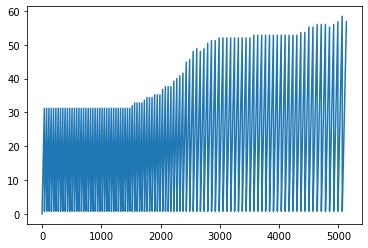

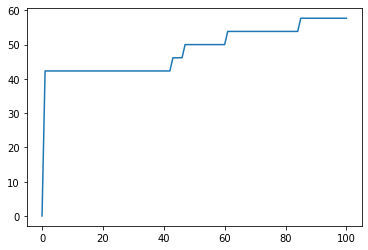

Melhor precisão de treinamento 58.39999999999992
Melhor precisão de teste 57.69230769230769
Melhor precisão de validação 59.259259259259245
Tempo de execução: 1.1442313194274902 Segundos


In [300]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 100)

Conseguimos melhorar consideravelmente os resultados com essa nova função de ativação.

### Bias
Algo que podemos fazer para melhorar a generalização da rede é adicionar o Bias, sendo uma constante que será considerada como um neurônio na camada de entrada.

In [250]:
previsores['bias'] = 1
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 100)

Melhor precisão de treinamento 73.33333333333319
Melhor precisão de teste 81.81818181818183
Melhor precisão de validação 73.91304347826087
Tempo de execução: 17.68507719039917 Segundos


Como podemos ver, a aplicação do bias também nos ajudou a melhorar os resultados da rede, chegando em torno de 80% de precisão.

Um outro parâmetro que pode ser otimizado é o domínio dos pesos, podemos alterar o mesmo para tentar buscar um nível de precisão maior.

In [ ]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 100, [-0.5, 0.5])

Utilizar o domínio entre -0.5 e 0.5 nos acrescentou um pequeno ganho de precisão com a função de custo padrão.

## Mean Squared Error e Root Mean Squared error
A função de custo que está sendo utilizada atualmente é a mais simples possível, onde comparamos a diferença entre a previsão atual com o valor esperado. Existem outras fórmulas um pouco mais completas que nos dão um nível de precisão maior em estimar os custos.

A primeira delas é a função Mean Squared Error, que possui a seguinte fórmula:
![](./images/mse.gif)
E a Root Mean Squared Error, que segue a mesma formula mas submetendo os resultados a uma raiz quadrada.

Essas duas funções de custo foram representadas pelos métodos *funcao_custo_mse* e *funcao_custo_rmse* respectivamente e foram feitos testes para comparar a eficácia de cada uma delas.

In [217]:
def funcao_custo_mse(valor_correto, valor_previsto):
    erro = list(np.array(valor_correto) - np.array(valor_previsto))
    erro_quadratico = list(map(lambda x: math.pow(x, 2), erro))
    soma_erro_quadratico = sum(erro_quadratico)

    return soma_erro_quadratico # / len(previsores) essa parte é apenas para atualização em epoca

In [218]:
def funcao_custo_rmse(valor_correto, valor_previsto):
    erro = list(np.array(valor_correto) - np.array(valor_previsto))
    erro_quadratico = list(map(lambda x: math.pow(x, 2), erro))
    soma_erro_quadratico = sum(erro_quadratico)

    return math.sqrt(soma_erro_quadratico) # / len(previsores) essa parte é apenas para atualização em epoca

In [226]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 500, [-0.5, 0.5])
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_rmse, 500, [-0.5, 0.5])

Melhor precisão de treinamento 79.99999999999983
Melhor precisão de teste 77.27272727272728
Melhor precisão de validação 77.27272727272728
Tempo de execução: 85.33861470222473 Segundos
Melhor precisão de treinamento 77.14285714285698
Melhor precisão de teste 90.90909090909092
Melhor precisão de validação 90.90909090909092
Tempo de execução: 87.92669677734375 Segundos


Podemos ver que nesse caso o *root mean squared error* foi a que obteve melhores resultados.


As redes perceptron, ainda que consideradas simples, possuem um conjunto grande de parâmetros a serem otimizados, que fazem toda diferença para conseguir melhores resultados.

# Qual o problema?
Utilizar a base de dados de vinhos contidos aqui: http://archive.ics.uci.edu/ml/datasets/Wine para prever qual o tipo de vinha (1, 2 ou 3) baseado nas suas características.

## Anásile exploratória dos dados
Conhecendo um pouco mais dos dados da base de dados.

In [276]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/wine.csv', header = 0)
dataframe.head()

,Wine,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [277]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Valores nulos:
Wine                    0
Alcohol                 0
Malic acid              0
Ash                     0
Alcalinity of ash       0
Magnesium               0
Total phenols           0
Flavanoids              0
Nonflavanoid phenols    0
Proanthocyanins         0
Color intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64


,Wine,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Nesse *dataset* todos os atributos são contínuos, inclusive a classe. Podemos notar que não existe nenhum valor vazio bem como aparentemente nenhum outlier/ruído.

## Normalização dos dados 
Assim como no problema da iris, esse dataset também precisa ser normalizando, ainda mais por conter uma quantidade maior de atributos previsores contínuos.

In [278]:
previsores = dataframe.iloc[:, 1:14] 
classe = dataframe['Wine']

In [279]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


A classe do tipo de vinho é distribuída em 1, 2 e 3, todavia para que meu método de codificar funcione ele precisa começar em 0, por isso, a classe de vinho foi submetida ao método de *transformar_categorico_em_numerico*, que vai transformá-la na sequência de 0, 1 e 2.

In [280]:
dict_classes = get_dicionario_classes(classe)
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
classe.value_counts()

1    71
0    59
2    48
Name: Wine, dtype: int64

Agora a classe vai ser codificada em uma array assim como aconteceu com a iris, pois temos novamente um problema do tipo multi-classe.

In [281]:
classe_codificada = codificar_classe()
classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
classe.head()

0    [1, 0, 0]
1    [1, 0, 0]
2    [1, 0, 0]
3    [1, 0, 0]
4    [1, 0, 0]
Name: Wine, dtype: object

Agora basta adicionar o neurônio na camada de entrada para ser o bias e executar o perceptron novamente para conferir os resultados da rede.

In [282]:
previsores['bias'] = 1

In [283]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 350, [-0.5, 0.5])

Melhor precisão de treinamento 72.79999999999987
Melhor precisão de teste 76.9230769230769
Melhor precisão de validação 66.66666666666666
Tempo de execução: 95.44159507751465 Segundos


# Qual o problema?
Selecionar conjunto da escolha